In [1]:
using Symbolics
using Latexify
using BenchmarkTools
include("RBFunctions.jl")
using Plots
using LinearAlgebra
using IterativeSolvers
using NearestNeighbors
include("LHI_Navier-stokes.jl")
using DoubleFloats
using Profile

In [166]:

μ = 0.0025
ρ = 1.0
@variables ϵ r x₁ x₂ u1 v1 u2 v2 ;
ϕ1 = r^7
ϕ2 = r^7

ϕ1 = substitute(ϕ1, r=>sqrt(x₁^2 + x₂^2))
ϕ2 = substitute(ϕ2, r=>sqrt(x₁^2 + x₂^2))

∂₁(exprs) = simplify(expand_derivatives(Differential(x₁)(exprs)))
∂₂(exprs) = simplify(expand_derivatives(Differential(x₂)(exprs)))

Δ(exprs) = ∂₁(∂₁(exprs)) + ∂₂(∂₂(exprs))
∂ₜ(exprs) = expand_derivatives(Differential(t)(exprs))

Φ_div = ([-∂₂(∂₂(ϕ1)) ∂₁(∂₂(ϕ1)) 0; ∂₁(∂₂(ϕ1)) -∂₁(∂₁(ϕ1)) 0; 0 0 ϕ2])

λu(x) = x[1]
λv(x) = x[2]
λp(x) = x[3]

λ1x(x) =  -(μ/ρ)*Δ(x[1]) + (μ/ρ)*∂₁(x[3])  +  u1*∂₁(x[1]) + v1*∂₂(x[1])
λ2x(x) =  -(μ/ρ)*Δ(x[2]) +  (μ/ρ)*∂₂(x[3]) + u1*∂₁(x[2]) + v1*∂₂(x[2])
λ3x(x) = x[1]
λ4x(x) = x[2]

λ1y(x) =  -(μ/ρ)*Δ(x[1]) -  (μ/ρ)*∂₁(x[3]) - u2*∂₁(x[1]) - v2*∂₂(x[1])
λ2y(x) =  -(μ/ρ)*Δ(x[2]) -  (μ/ρ)*∂₂(x[3]) -u2*∂₁(x[2]) - v2*∂₂(x[2])
λ3y(x) = x[1]
λ4y(x) = x[2]

display(Φ_div)

F_A = construct_kernel_array(Φ_div,[λu,λv,λ1x,λ2x,λ3x,λ4x],[λu,λv,λ1y,λ2y,λ3y,λ4y])
compile_kernel_array_NS(F_A,:F_A)


F_B = construct_kernel_array(Φ_div,[λ1x,λ2x],[λu,λv,λ1y,λ2y,λ3y,λ4y])

compile_kernel_array_NS(F_B,:F_B)

P_list2D = generate_2D2_div_free_poly_basis(4)
P_list1D = generate_2D1_poly_basis(4)
P_list = []
for p2 in P_list2D
    append!(P_list, [vcat(p2,Num(0.0))])
end
for p1 in P_list1D[2:end]
    append!(P_list, [vcat(Num(0.0),Num(0.0),p1)])
end
#display(P_list)
N_poly = length(P_list)
F_PA = apply_functionals_to_polynomials([λu,λv,λ1x,λ2x,λ3x,λ4x],P_list)

compile_polynomials_NS(F_PA,:F_PA)

F_PB = apply_functionals_to_polynomials([λ1x,λ2x],P_list)
display(F_PB)
compile_polynomials_NS(F_PB,:F_PB)


println("done")



3×3 Matrix{Num}:
 -7(sqrt(x₁^2 + x₂^2)^5) - 35(x₂^2)*(sqrt(x₁^2 + x₂^2)^3)  …                    0
                            35x₁*x₂*(sqrt(x₁^2 + x₂^2)^3)                       0
                                                        0     sqrt(x₁^2 + x₂^2)^7

2×34 Matrix{Num}:
 0.0  v1     u1  2v1*x₂ - 0.005  …  0.0075x₂*(x₁^2)  0.01(x₁^3)
 0.0   0.0  -v1           0.0       0.0025(x₁^3)     0.0

done


2×76 Matrix{Float64}:
 0.0  0.0        0.0       0.0       …  1.0       1.0       1.0       1.0
 0.0  0.0526316  0.105263  0.157895     0.842105  0.894737  0.947368  1.0

[0.0, 0.0]
[0.0, 1.0]
[1.0, 0.0]
[1.0, 1.0]


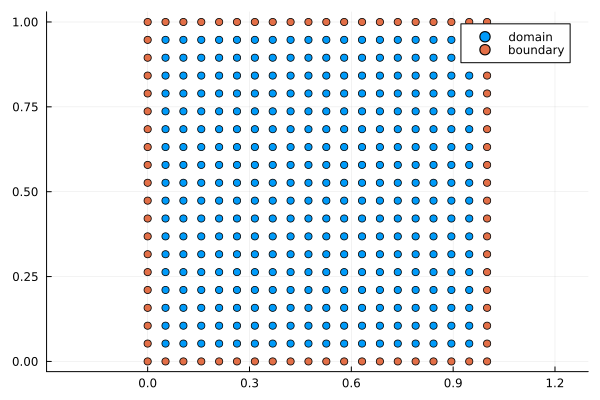

In [168]:
#generate points for lid_driven_cavity
N_side =20
I_points, B_points = generate_2D_equally_spaced_points(N_side)

N_I = size(I_points)[2]


#all_points = [domain_p boundary_p]zzzzzzz
println(B_points[:,1])
println(B_points[:,N_side])
println(B_points[:,3*N_side-3])
println(B_points[:,4*N_side-4])
#B_points = B_points[:, setdiff(1:end,[N_side,4*N_side-4])]
N_B = size(B_points)[2]
N_tot = N_I + N_B 
All_points = hcat(I_points, B_points)
display(B_points)
scatter(I_points[1,:],I_points[2,:],label="domain",aspect_ratio = :equal)
scatter!(B_points[1,:],B_points[2,:],label="boundary")

In [169]:
@variables x y;
dx(exprs) = simplify(expand_derivatives(Differential(x)(exprs)))
dy(exprs) = simplify(expand_derivatives(Differential(y)(exprs)))

u = -y*sin(x^2 + y^2)
v = x*sin(x^2 + y^2)
p = sin(x-y)

#u = 20*x*y^3
#v = 5*x^4 - 5*y^4
#p = 60*x*x*y - 20*y*y*y 
display(dx(u)+dy(v))
f1 = 0.0#-(μ/ρ)*(dx(dx(u)) + dy(dy(u))) + dx(p)/ρ
f2 = 0.0#-(μ/ρ)*(dx(dx(v)) + dy(dy(v))) + dy(p)/ρ
display(f1)
display(f2)
f1 = eval(build_function(f1,x,y))
f2 = eval(build_function(f2,x,y))
true_v1 = eval(build_function(u,x,y))
true_v2 = eval(build_function(v,x,y))
f1(12,2)
function gu(x,y)
    
    if abs(y-1) < 1e-10 
        return 1#-(0.5-x)^2 + 0.25
    else
        return 0.0
    end
    
    #return true_v1(x,y)
end
gv(x,y) = 0.0#true_v2(x,y)
gu(0.9,1)


0

0.0

0.0

1

In [170]:
include("LHI_Navier-stokes.jl")
param = 0
k = 50
U = zeros(2*N_I)
kdtree = KDTree(All_points,Euclidean(),leafsize = 3)
neighbours,_ = knn(kdtree, I_points, k, true) 
#typeof(neighbours)
sol =solve_linearized_NS(neighbours,N_poly,I_points,B_points,U,f1,f2,gu,gv,param,k)
println("done")

max local cond number: 9.02140082769909e7
done


max error: 0.0007906414123298733


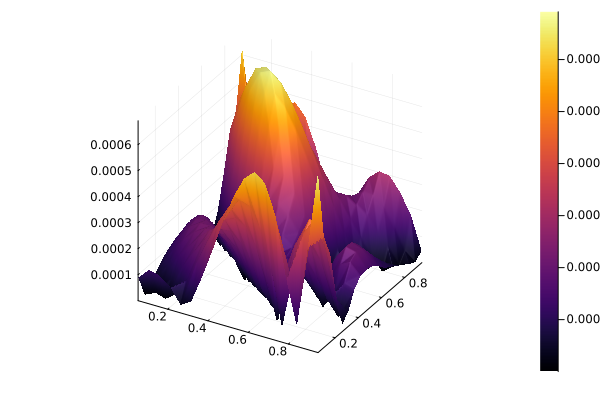

In [7]:
true_sol = vcat(true_v1.(I_points[1,:],I_points[2,:]),
                true_v2.(I_points[1,:],I_points[2,:]))
err = abs.(sol-true_sol)
println("max error: ",maximum(err))
surface(I_points[1,:],I_points[2,:],err[1:N_I])

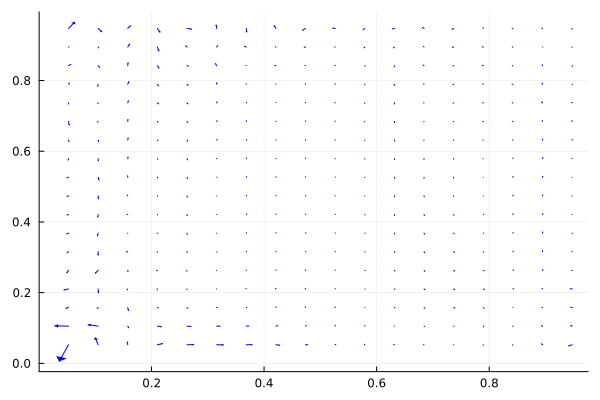

In [174]:
"""
function plot_arrow!(x1,y1,x2,y2)
    color = :blue
    arr_width = 0.2
    vx = x2-x1
    vy = y2 -y1
    l_arr = sqrt(vx*vx+vy*vy)
    pqx= x1+3*(x2-x1)/4
    pqy= y1+3*(y2-y1)/4 # quarterpoint

    vpx = 1
    vpy = -vx/vy
    lp = sqrt(vpx*vpx + vpy*vpy)
    vpx = vpx/lp
    vpy = vpy/lp 

    p1ax = pqx + vpx*l_arr*arr_width
    p1ay = pqy + vpy*l_arr*arr_width

    p2ax = pqx - vpx*l_arr*arr_width
    p2ay = pqy - vpy*l_arr*arr_width

    plot!([x1,x2],[y1,y2],c=color,label = false) # line
    trian = Shape([(p1ax, p1ay),(p2ax,p2ay), (x2,y2), (p1ax, p1ay)])
    plot!(trian, c = color,label = false,linewidth = 0)
end

function visualize_vec_field(Points,u,v)
    scale = 0.05
    vel = sqrt.(u.^2 .+ v .^2)
    mx = maximum(vel)
    #print(size(Points))
    plot()
    for i in 1:size(Points)[2]
        px,py = Points[:,i]
        #print(px,py)
        #plot!([px,px+scale*u[i]/mx],[py,py+scale*v[i]/mx],label = false,arrow = arrow(),)
        plot_arrow!(px,py,px+scale*u[i]/mx,py+scale*v[i]/mx)
    end
    plot!()
end
"""

visualize_vec_field(I_points,sol[1:N_I],sol[1+N_I:end])
#visualize_vec_field(I_points,sol[1:N_I],sol[1+N_I:end])

In [172]:
U = zeros(N_I*2)
tst_array= zeros(N_I*2,5)
for i in 1:5
    sol =solve_linearized_NS(neighbours,N_poly,I_points,B_points,U,f1,f2,gu,gv,param,k)
    tst_array[:,i] .= sol
    U = sol
end



max local cond number: 9.02140082769909e7


max local cond number: 8.000709398799037e8


max local cond number: 4.8054545432701845e9


max local cond number: 5.609714233480433e8


max local cond number: 4.450816899972496e9


In [173]:
tst_array

648×5 Matrix{Float64}:
  0.0595654     2.0344      0.0740263    0.265929    -4.74357
  0.0270099     0.826377   -0.0368468   -0.11879     -7.0236
  0.0286834     0.419774   -0.00619021  -0.360201    -1.4515
  0.0134325     0.078921    0.284375    -0.288045    -2.36386
  0.000231208   0.0650259   0.163512    -0.484001    -0.900505
 -0.0177634    -0.0322952  -0.0444241   -0.309642    -0.723735
 -0.0332889    -0.121175   -0.256573    -0.0557231   -0.892217
 -0.0442016    -0.201236   -0.309706     0.0359536   -0.6841
 -0.0483832    -0.259866   -0.213017     0.134377    -0.796465
 -0.0446155    -0.325575   -0.209268     0.156621    -0.799421
  ⋮                                                  
 -0.0901207    -0.780501    0.605156    -0.0811665    0.0791838
 -0.0897321    -0.783919    0.519983    -0.211476     0.348284
 -0.098023     -0.842368    0.432462    -0.32665      0.620516
 -0.115915     -0.934625    0.357977    -0.491597     0.615318
 -0.152912     -1.07218     0.298686    -0.50071